### Setting Up and Loading a Data Subset
Load the data. Since time is limited and the full dataset is large, the best practice is to start by creating a smaller, random subset to work with. This will make analysis and feature engineering much faster.

In [3]:
# Install the required libraries
! pip install -q wikihowunofficialapi textstat

In [4]:
import pandas as pd
import wikihowunofficialapi as wha
import textstat # A library for calculating readability scores

In [5]:
# Load the full dataset from your .pickle file
full_data = pd.read_pickle('wikihow.pickle') # Make sure to use your file path

# Create a smaller, manageable subset of 1000 random articles for now
# Set a random_state so you get the same subset every time you run it
data = full_data.sample(n = 1000, random_state = 42)

In [6]:
print(f"Working with a subset of {len(data)} articles.")
data.head()

Working with a subset of 1000 articles.


,info
13225,How to Memorize Words for a Spelling Bee
10418,How to Discipline an Autistic Child
13346,How to Get out of a Nondisclosure Agreement
12239,How to Cope with Your Ex Dating Someone New
2641,How to Relieve School Anxiety for Special Need...


### Exploratory Data Analysis (EDA)
Before creating features, we need to understand the raw data. The code below will calculate some basic properties and visualize their distributions using histograms.

Starting data processing...
Data processing complete. New columns 'num_steps' and 'num_methods' are added.
Generating plots...


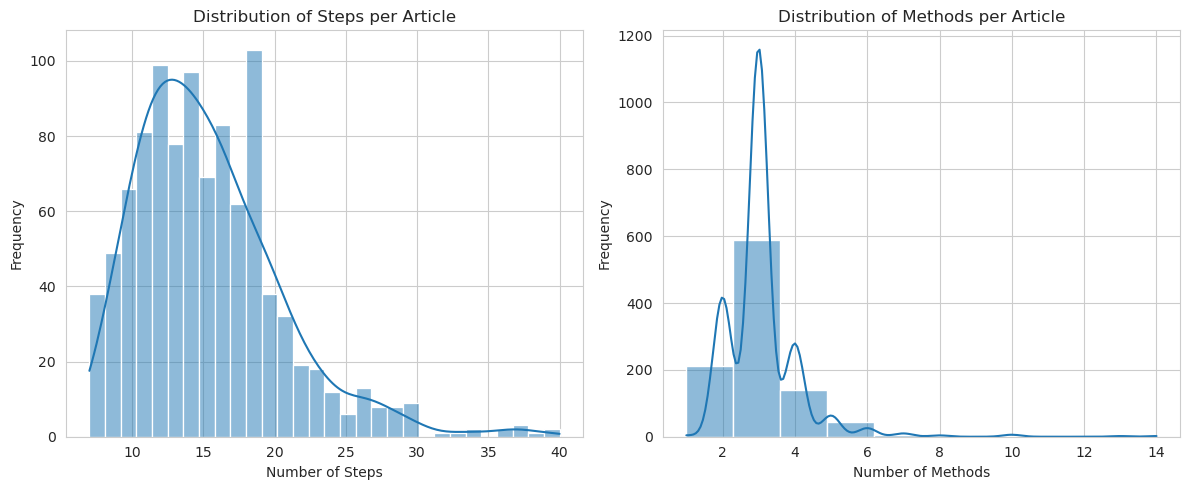

Plots generated successfully.


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Processing Step ---
# Create lists to hold the metrics we calculate from each article.

print("Starting data processing...")
num_steps_list = []
num_methods_list = []

# Loop through each row in our data subset
for index, row in data.iterrows():
    try:
        article = row['info']
        # Calculate total steps by summing steps in each method
        total_steps = sum(len(method.steps) for method in article.methods)
        
        num_steps_list.append(total_steps)
        num_methods_list.append(article.n_methods)
        
    except Exception as e:
        # If an article is malformed or causes an error, we'll add 0.
        num_steps_list.append(0)
        num_methods_list.append(0)

# --- Column Creation Step ---
# Add the newly created lists as columns to the DataFrame.
data['num_steps'] = num_steps_list
data['num_methods'] = num_methods_list
print("Data processing complete. New columns 'num_steps' and 'num_methods' are added.")


# --- Plotting Step ---
# Now that we are certain the columns exist, we can create the plots.

print("Generating plots...")
sns.set_style("whitegrid")
plt.figure(figsize=(12, 5))

# Plot for 'num_steps'
plt.subplot(1, 2, 1)
sns.histplot(data['num_steps'], bins=30, kde=True)
plt.title('Distribution of Steps per Article')
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')

# Plot for 'num_methods'
plt.subplot(1, 2, 2)
sns.histplot(data['num_methods'], bins=10, kde=True)
plt.title('Distribution of Methods per Article')
plt.xlabel('Number of Methods')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
print("Plots generated successfully.")

### Feature Engineering
The code below creates a function that extracts several numerical features from each article and then applies it to the dataset. We will use the textstat library to automatically calculate readability scores.

In [ ]:
def create_features(article):
    """
    This function takes a single wikiHow article object and returns a
    dictionary of engineered features.
    """
    features = {}
    
    try:
        # 1. Structural Features (already calculated in your EDA)
        # We recalculate them here to put them in the final features DataFrame
        features['num_methods'] = article.n_methods
        features['num_steps'] = sum(len(method.steps) for method in article.methods)

        # 2. Linguistic & Readability Features
        # Combine all text into one block for analysis
        full_text = article.intro
        for method in article.methods:
            for step in method.steps:
                full_text += " " + step.description
        
        # Avoid division by zero for empty articles
        if not full_text:
            return None

        features['word_count'] = len(full_text.split())
        
        # Using textstat to calculate standard readability scores
        features['flesch_reading_ease'] = textstat.flesch_reading_ease(full_text)
        features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(full_text)
        
        return features

    except Exception as e:
        return None # Return None for any articles that cause errors

# Apply this function to every article in your dataset
# This might take a minute to run on your 1000-article subset
feature_list = [create_features(row['info']) for index, row in data.iterrows()]

# Create a new DataFrame from our list of feature dictionaries
features_df = pd.DataFrame([f for f in feature_list if f is not None])

print("Engineered features for our model:")
features_df.head()